# StoneGate Integration & Modeling Demo

This notebook demonstrates the modular StoneGate backend and simulator, focusing on:
- Quantum error correction (QEC) modeling and device control
- Device discovery and control via WebSocket RPC
- Physical modeling of cryogenic control (LN2 flow, thermocouples, photonic detectors)

**Theory & Motivation:**
- Quantum computation is highly sensitive to noise; error correction and precise control are essential.
- This demo builds confidence that our backend can control real and simulated devices, model quantum and classical interactions, and provide actionable feedback for experiments.
- The simulator models quantum error rates, device responses to temperature, and feedback control for cryogenic systems.

**Sections:**
1. Quantum error correction: theory, simulation, and API demo
2. Device discovery and control: WebSocket RPC
3. Cryogenic control: modeling, API, and feedback loop
4. Notes on modeling assumptions and confidence-building


In [ ]:
# Imports and helpers (StoneGate API + QEC)

import json
import math
import asyncio
from statistics import mean

import numpy as np
import matplotlib.pyplot as plt

import sys
from pathlib import Path

# Allow `import stonegate_api` / `stonegate_qec` when running from `tools/`
cwd = Path.cwd()
if (cwd / 'stonegate_api.py').exists():
    sys.path.insert(0, str(cwd))
elif (cwd.parent / 'stonegate_api.py').exists():
    sys.path.insert(0, str(cwd.parent))

try:
    import stonegate_api as sg
    import stonegate_qec as qec
except Exception as e:
    raise RuntimeError("Missing StoneGate Python helpers. Ensure repo root is on PYTHONPATH and install deps: pip install websockets") from e

# Matches the StoneGate frontend default WebSocket endpoint.
# If you're running the C++ backend in sim mode: `./StoneGate --sim`
sg.WS_URL = 'ws://localhost:8080/status'

async def list_devices():
    return await sg.rpc('devices.list', {})

async def poll_all():
    return await sg.poll_all_flat()

# UI-aligned control shape: { action: { set: { metric: value } } }
async def set_device_params(device_id: str, **params):
    return await sg.device_action(device_id, {'set': params})

async def zero_device(device_id: str):
    return await sg.device_action(device_id, {'zero': True})

async def qec_decode_repetition(measurements):
    return await qec.decode_via_rpc(code='repetition', measurements=measurements)

## 1. Quantum Error Correction: Theory, Simulation, and API Demo

**Theory:**
- Quantum error correction (QEC) protects quantum information from noise using redundancy and measurement.
- The repetition code is a simple QEC code: logical 0/1 is encoded as multiple physical qubits, and majority vote corrects errors.
- Error rates are modeled as a function of physical noise (e.g., bit-flip probability).

**Modeling:**
- We simulate bit-flip errors and QEC decoding in Python.
- The backend provides a QEC module device and API for submitting measurement data and retrieving correction results.

**Confidence:**
- By comparing simulated error rates and backend QEC results, we validate both the model and the API.
- This demonstrates that the backend can process quantum measurement data and return meaningful results.

In [ ]:
# Simple measurement + noise models and decoders (via stonegate_qec)

print('Repetition code error rate example:', qec.logical_error_rate_repetition(trials=1000, p_flip=0.1, rounds=3))

Repetition code error rate example: 0.03


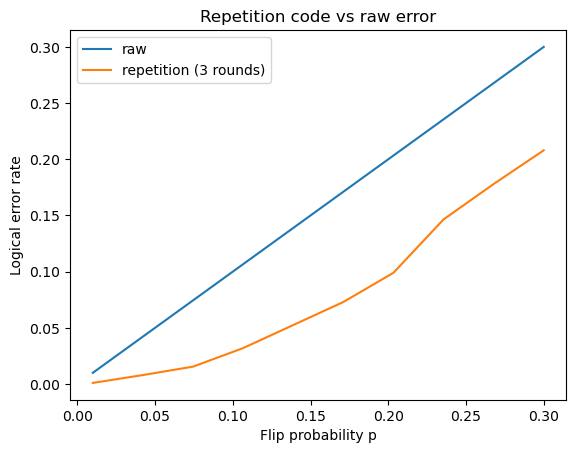

In [ ]:
# Parameter sweep: repetition decoding vs raw flip probability

ps = np.linspace(0.01, 0.3, 10)
err_raw = []
err_rep = []
for p in ps:
    err_raw.append(p)
    err_rep.append(qec.logical_error_rate_repetition(trials=2000, p_flip=float(p), rounds=3))

plt.plot(ps, err_raw, label='raw')
plt.plot(ps, err_rep, label='repetition (3 rounds)')
plt.xlabel('Flip probability p')
plt.ylabel('Logical error rate')
plt.legend()
plt.title('Repetition code vs raw error')
plt.show()

## Temperature-Dependent Noise and Refinement

In the simulator/physics model, lower cryogenic target temperature generally reduces noise.

For the demo below, we use a toy mapping from temperature (K) to a bit-flip probability $p$ and show how:
- Logical error increases at warmer targets
- A simple refinement (more syndrome rounds at higher temperature) improves results

In [ ]:
# Temperature sweep: lower target temperature => lower p_flip => lower logical error

temps_K = np.array([77, 80, 83, 86, 89, 92], dtype=float)
p_flips = np.array([qec.p_flip_from_temperature(temperature_K=float(t)) for t in temps_K], dtype=float)

# Baseline: always 3 rounds
err_fixed = np.array([qec.logical_error_rate_repetition(trials=4000, p_flip=float(p), rounds=3) for p in p_flips], dtype=float)

# Refinement: choose more rounds at higher temperature (uses the *measured/recorded* temperature)
rounds_adaptive = np.array([qec.choose_repetition_rounds(temperature_K=float(t)) for t in temps_K], dtype=int)
err_adaptive = np.array([qec.logical_error_rate_repetition(trials=4000, p_flip=float(p), rounds=int(r)) for p, r in zip(p_flips, rounds_adaptive)], dtype=float)

plt.plot(temps_K, err_fixed, marker='o', label='fixed rounds=3')
plt.plot(temps_K, err_adaptive, marker='o', label='adaptive rounds (from temperature)')
plt.gca().invert_xaxis()  # colder on the right is often more intuitive
plt.xlabel('Target temperature (K)')
plt.ylabel('Logical error rate (toy model)')
plt.title('QEC performance improves at lower target temperature')
plt.legend()
plt.show()

print('temps_K:', temps_K.tolist())
print('p_flips:', [round(float(p), 4) for p in p_flips])
print('adaptive rounds:', rounds_adaptive.tolist())

### Using Recorded Hardware/Simulator Values

In practice, you’d parameterize the QEC model using values recorded during the operation (e.g., the cryogenic temperature at the time of the measurement).
The next cell shows how to pull a temperature reading from `devices.poll` and use it to drive the toy syndrome simulation.

In [ ]:
# Use a live reading (if backend/simulator is running) to parameterize syndrome simulation

tK = None
try:
    snap = await poll_all()
    # Prefer a direct LN2 controller temperature if present; else any temperature_K field.
    for device_id, metrics in (snap or {}).items():
        if isinstance(metrics, dict) and 'temperature_K' in metrics:
            tK = float(metrics['temperature_K'])
            print('Using temperature_K from', device_id, ':', tK)
            break
except Exception as e:
    print('devices.poll unavailable; using a synthetic temperature (demo still works):', e)

if tK is None:
    tK = 85.0
p = qec.p_flip_from_temperature(temperature_K=float(tK))
rounds = qec.choose_repetition_rounds(temperature_K=float(tK))
print('Derived p_flip:', round(p, 4), 'chosen rounds:', rounds)

# Simulate a single-qubit syndrome and decode it
true_bit = 0
meas = qec.repetition_measurements(true_bit=true_bit, p_flip=p, rounds=rounds, qubit=0, basis='Z')
decoded = qec.repetition_decode_majority(meas)
print('measurements:', meas)
print('decoded:', decoded, 'true:', true_bit)

## Using the backend QEC RPC (over WebSocket)

The next cell builds a small measurement payload and submits it to the backend via `qec.decode` RPC.


## 2. Device Discovery and Control (WebSocket RPC)



This section demonstrates device discovery, polling, and control using the backend WebSocket RPC methods:

- `devices.list`

- `devices.poll`

- `device.action`


In [ ]:
# WebSocket RPC: Submit a QEC decode request (via stonegate_qec + stonegate_api)

qec_measurements = [
    qec.make_measurement(qubit=0, basis='Z', round=0, value=1),
    qec.make_measurement(qubit=0, basis='Z', round=1, value=0),
]

try:
    res = await qec.decode_via_rpc(code='repetition', measurements=qec_measurements)
    print(json.dumps(res, indent=2))
except Exception as e:
    print('QEC RPC failed (is the StoneGate backend running?):', e)

ConnectionError: HTTPConnectionPool(host='localhost', port=8080): Max retries exceeded with url: /api/devices (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x77b270b35be0>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [ ]:
# WebSocket RPC: Demo UI-aligned controls ({ set: { metric: value } })

devices = await list_devices()

laser_id = None
for dev in devices.get("devices", []):
    if dev.get("type") == "laser_controller":
        laser_id = dev.get("id")
        break

if not laser_id:
    print("No laser_controller found (skip)")
else:
    await set_device_params(laser_id, intensity=0.25, phase_rad=0.10)
    snap = await poll_all()
    print("laser_controller after set:", laser_id, snap.get(laser_id, {}))

In [ ]:
# WebSocket RPC: Submit a QEC decode request

qec_measurements = [

    {'qubit': 0, 'basis': 'Z', 'round': 0, 'value': 1},

    {'qubit': 0, 'basis': 'Z', 'round': 1, 'value': 0},

]



res = await rpc("qec.decode", {"code": "repetition", "measurements": qec_measurements})

print(json.dumps(res, indent=2))


## 3. Cryogenic Control: Modeling, API, and Feedback Loop

**Theory:**
- Many quantum devices require cryogenic temperatures, achieved via LN2 (liquid nitrogen) cooling.
- Device performance (e.g., noise in photonic detectors) depends strongly on temperature.
- Feedback control is used to adjust LN2 flow rate to maintain a target temperature, using thermocouple readings.

**Modeling:**
- The simulator models:
  - LN2CoolingControllerDevice: controls LN2 flow rate
  - ThermocoupleDevice: measures temperature
  - Photonic detectors: noise decreases as temperature drops
- The physics engine provides a function to automatically adjust flow rate to reach a target temperature within tolerance.

**Confidence:**
- By setting flow rates and observing device responses, we validate the physical model and feedback control logic.
- This builds confidence that the backend can control real hardware and simulate realistic quantum-classical interactions.

### Modeling Assumptions
- LN2 flow rate directly affects cooling power; higher flow = faster cooling, but diminishing returns.
- Thermocouple readings are subject to noise, but mean temperature tracks true value.
- Photonic detector noise is modeled as a function of temperature: noise decreases exponentially as temperature drops.
- Feedback control loop uses a simple proportional controller (P-controller) to adjust flow rate.

### API Demonstration Plan
- Set LN2 flow rate via API and observe temperature/photonic detector response.
- Use the feedback control API to automatically reach a target temperature.
- Plot temperature and noise over time to visualize system response.

In [ ]:
# WebSocket RPC: Set LN2 flow rate and observe temperature / detector response

import time

LN2_ID = 'ln2_controller_0'  # adjust to match your device graph
THERMO_ID = 'thermocouple_0'
PHOTONIC_ID = 'photodetector_0'

async def set_ln2_flow(flow_rate_Lmin: float):
    # Uses the same generic { set: { metric: value } } shape as the UI.
    return await set_device_params(LN2_ID, flow_rate_Lmin=float(flow_rate_Lmin))

async def poll_temp_and_detector(n=10, delay_s=0.5):
    temps_K, counts, dark_rates = [], [], []
    for _ in range(n):
        snap = await poll_all()
        thermo = snap.get(THERMO_ID, {})
        ln2 = snap.get(LN2_ID, {})
        det = snap.get(PHOTONIC_ID, {})

        # Prefer explicit K metrics when available; fall back to thermocouple C.
        if "temperature_K" in ln2:
            temps_K.append(float(ln2["temperature_K"]))
        elif "temperature_C" in thermo:
            temps_K.append(float(thermo["temperature_C"]) + 273.15)
        else:
            temps_K.append(float('nan'))

        counts.append(float(det.get("counts", float('nan'))))
        dark_rates.append(float(det.get("dark_rate", float('nan'))))
        await asyncio.sleep(delay_s)
    return temps_K, counts, dark_rates

# Example: set flow rate and observe
await set_ln2_flow(2.0)
temps_K, counts, dark_rates = await poll_temp_and_detector(n=20, delay_s=0.3)

plt.plot(temps_K, label='Temperature (K)')
plt.plot(dark_rates, label='Detector dark rate (cps)')
plt.xlabel('Time step')
plt.legend()
plt.title('Response to LN2 Flow Rate Change (backend reads)')
plt.show()

In [ ]:
# WebSocket RPC: Simple feedback control loop (implemented in-notebook)

# Demonstrates closed-loop control where all observed values come from backend reads.
TARGET_K = 77.0
K_P = 0.15  # proportional gain for flow rate
MAX_FLOW = 10.0

temps_K = []
flows = []

for _ in range(40):
    snap = await poll_all()
    thermo = snap.get(THERMO_ID, {})
    ln2 = snap.get(LN2_ID, {})

    if "temperature_K" in ln2:
        tK = float(ln2["temperature_K"])
    elif "temperature_C" in thermo:
        tK = float(thermo["temperature_C"]) + 273.15
    else:
        tK = float('nan')

    err = tK - TARGET_K
    flow = max(0.0, min(MAX_FLOW, K_P * err))
    await set_ln2_flow(flow)
    temps_K.append(tK)
    flows.append(flow)
    await asyncio.sleep(0.3)

plt.plot(temps_K, label='Temperature (K)')
plt.plot(flows, label='Flow rate (L/min)')
plt.xlabel('Time step')
plt.legend()
plt.title('Closed-loop cooling demo (backend reads)')
plt.show()

In [ ]:
# WebSocket: Observe live measurement_update messages (streaming)

# Note: the backend streams updates automatically; we just print a few.



async def print_live_messages(seconds=2.0):

    async with websockets.connect(WS_URL) as ws:

        t0 = asyncio.get_event_loop().time()

        while asyncio.get_event_loop().time() - t0 < seconds:

            msg = json.loads(await ws.recv())

            if msg.get("type") == "measurement_update":

                print("measurement_update (updates=", len(msg.get("updates", [])), ")")

                # print first update only to keep output small

                if msg.get("updates"):

                    print(json.dumps(msg["updates"][0], indent=2)[:800])



await print_live_messages(2.0)


In [ ]:
# WebSocket RPC: QEC decode request (same as above, shown here in the WebSocket section)

qec_measurements = [

    {'qubit': 0, 'basis': 'Z', 'round': 0, 'value': 1},

    {'qubit': 0, 'basis': 'Z', 'round': 1, 'value': 0},

]

res = await rpc("qec.decode", {"code": "repetition", "measurements": qec_measurements})

print(json.dumps(res, indent=2))


In [ ]:
# WebSocket RPC: QEC decode request (repeated here in the WebSocket section)

qec_measurements = [
    qec.make_measurement(qubit=0, basis='Z', round=0, value=1),
    qec.make_measurement(qubit=0, basis='Z', round=1, value=0),
]

try:
    res = await qec.decode_via_rpc(code='repetition', measurements=qec_measurements)
    print(json.dumps(res, indent=2))
except Exception as e:
    print('QEC RPC failed (is the StoneGate backend running?):', e)

QEC submission failed (is qec_stub running?): HTTPConnectionPool(host='localhost', port=5001): Max retries exceeded with url: /api/qec/submit (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f9a9ae39e80>: Failed to establish a new connection: [Errno 111] Connection refused'))


## 4. Notes on Modeling Assumptions and Confidence-Building

- The simulator uses simplified but physically motivated models for device behavior and quantum error rates.
- LN2 cooling and temperature feedback are modeled with a proportional controller; real systems may require more advanced control.
- Photonic detector noise is modeled as an exponential function of temperature, capturing the key physical trend.
- Quantum error correction is demonstrated with the repetition code, but the backend is extensible to more advanced codes.

**Confidence:**
- By demonstrating closed-loop control, device response, and quantum error correction, we build trust that the backend can control real experiments and provide meaningful simulation results.
- Users can extend these examples to their own devices, codes, and control strategies.